In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from torch_geometric.loader import DataLoader
from dataset_copy import *
from model import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

/Users/ed/miniforge3/envs/XAIcaptum/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cpu'

Dataset type:  <class 'dataset_copy.ChiralLigands'>
Dataset node features:  6
Dataset length:  <bound method ChiralLigands.len of ChiralLigands(343)>
Dataset sample:  Data(x=[92, 6], edge_index=[2, 196], edge_attr=[196, 2], y=[1], category=[1], ligand='C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2', substrate='O=C1C=CCC1', boron='c1ccc(B2OB(c3ccccc3)OB(c3ccccc3)O2)cc1', index=0)
Sample features:  tensor([[6., 3., 3., 0., 1., 0.],
        [6., 3., 3., 0., 1., 0.],
        [6., 4., 4., 0., 0., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 4., 4., 0., 1., 1.],
        [6., 3., 3., 0., 1., 0.],
        [6., 3., 3., 0., 1., 0.],
        [6., 4., 4., 0., 0., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1., 1., 0.],
        [6., 3., 3., 1.

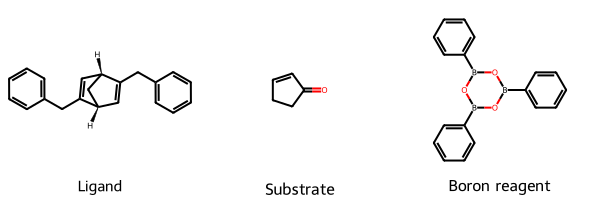

In [4]:
ligands = ChiralLigands(root = '/Users/ed/Documents/PhD_Documents/Experiments/ChiralLigands/Data/Combined/', filename = 'Combined.csv')

print("Dataset type: ", type(ligands))
print("Dataset node features: ", ligands.num_features)
print("Dataset length: ", ligands.len)
print("Dataset sample: ", ligands[0])
print('Sample features: ',  ligands[0].x)
print('Sample outcome: ',  ligands[0].y)

ms = [ligands[0].ligand, ligands[0].substrate, ligands[0].boron]
ms = [Chem.MolFromSmiles(mol) for mol in ms]
Chem.Draw.MolsToGridImage(ms,molsPerRow=3,subImgSize=(200,200),legends=['Ligand', 'Substrate', 'Boron reagent']) 

In [5]:
model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=False)
#model = GAT_loop(data.num_features, embedding_size = 1, gnn_layers=1, nheads=1, concat=False)
model.to(device)

GCN_loop(
  (initial_conv): GCNConv(6, 64)
  (conv_layers): ModuleList(
    (0): GCNConv(64, 64)
  )
  (merge): Linear(in_features=128, out_features=64, bias=True)
  (readout1): Linear(in_features=128, out_features=64, bias=True)
  (readout2): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

In [7]:
categories = np.array([ligands[i].category.detach().numpy() for i in range(len(ligands))])
x = [ligands[i].x.detach().numpy() for i in range(len(ligands))]

In [8]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, categories)):
    train_idx.append(train)
    test_idx.append(test)

In [9]:
i = 4
train_loader = DataLoader(ligands[train_idx[i]], batch_size=40, shuffle=True)
test_loader = DataLoader(ligands[test_idx[i]], batch_size=40, shuffle=False)

In [10]:
def calculate_metrics(y_pred, y_true, epoch, type):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    
    if epoch % 100 == 0:
        print('\n \n' + type)
        print(f"R2 score: {r2:.2f}")
        print(f"Mean absolute error: {mae:.2f}")
        print(f"Root mean squared error: {rmse:.2f}")

    return r2, mae, rmse

In [11]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))
      loss.backward()  
      # Update using the gradients
      optimizer.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [12]:
def test(epoch):

    all_preds = []
    all_y = []
    all_ligands = []
    all_substrates = []
    all_borons = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in test_loader:
      # Use GPU
      batch.to(device)  
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))
  
      total_loss += loss.item()
      step += 1

      all_preds.append(pred.cpu().detach().numpy())
      all_y.append(batch.y.cpu().detach().numpy())
      all_ligands.append(batch.ligand)
      all_substrates.append(batch.substrate)
      all_borons.append(batch.boron)

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel()
    all_ligands = np.expand_dims(np.concatenate (all_ligands).ravel(), axis = 1)
    all_substrates = np.expand_dims(np.concatenate (all_substrates).ravel() , axis = 1)
    all_borons = np.expand_dims(np.concatenate (all_borons).ravel() , axis = 1)
    mols = np.concatenate([all_ligands, all_substrates, all_borons], axis = 1)
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics, mols

In [13]:
epochs = 151

loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []

prec_train = []
prec_test = []

rec_train = []
rec_test = []

roc_train = []
roc_test = []

best_loss = 10_000
early_stopping_counter =0

for epoch in range (epochs):
            
    if early_stopping_counter <= 1000:
        # Training
        model.train()
        loss, pred, label, metrics = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()

        if epoch % 5 == 0:
            loss_train.append(loss) 
            prec_train.append(metrics[0])
            rec_train.append(metrics[1])
            roc_train.append(metrics[2])

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train Loss {loss}")
            pred_train.append(pred)
            labels_train.append(label)

                # Testing
            
        if epoch % 5 == 0:
            model.eval()
            loss, pred, label, metrics, mols = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if float(loss) < best_loss:
                best_loss = loss
                early_stopping_counter = 0
                best_pred = pred
                best_y = label
                best_r2 = metrics[0]
                best_mae = metrics[1]
                best_rmse = metrics[2]
                best_epoch = epoch
                best_mols = mols

            else:
                early_stopping_counter += 1

            
            loss_test.append(loss)
            prec_test.append(metrics[0])
            rec_test.append(metrics[1])
            roc_test.append(metrics[2])

            if epoch % 10 == 0:
                print(f"Epoch {epoch} | Test Loss {loss}")
                pred_test.append(pred)
                labels_test.append(label)
    
        last_epoch = epoch
                
    else:
        print("Early stopping due to no improvement.")
        print(f'Best loss was {best_loss}')
        last_epoch = epoch
        #break

print(f'Finishing training with best test loss: {best_loss}')
print(f'Best test r2: {best_r2}')
print(f'Best test mae: {best_mae}')
print(f'Best test rmse: {best_rmse}')


 
train
R2 score: -0.31
Mean absolute error: 33.32
Root mean squared error: 46.90
Epoch 0 | Train Loss 46.18944549560547

 
test
R2 score: -0.07
Mean absolute error: 39.56
Root mean squared error: 41.82
Epoch 0 | Test Loss 41.82257843017578
Epoch 10 | Train Loss 40.791175842285156
Epoch 10 | Test Loss 40.03898620605469
Epoch 20 | Train Loss 40.72513961791992
Epoch 20 | Test Loss 38.332923889160156
Epoch 30 | Train Loss 39.75047302246094
Epoch 30 | Test Loss 37.84268569946289
Epoch 40 | Train Loss 38.2255744934082
Epoch 40 | Test Loss 37.014747619628906
Epoch 50 | Train Loss 38.45989990234375
Epoch 50 | Test Loss 38.21794509887695
Epoch 60 | Train Loss 35.93305206298828
Epoch 60 | Test Loss 37.49363327026367
Epoch 70 | Train Loss 30.75970458984375
Epoch 70 | Test Loss 30.522008895874023
Epoch 80 | Train Loss 31.484418869018555
Epoch 80 | Test Loss 32.05977249145508
Epoch 90 | Train Loss 26.53708839416504
Epoch 90 | Test Loss 28.219364166259766

 
train
R2 score: 0.59
Mean absolute erro

In [14]:
print(f'Best test precision: {best_r2}')
print(f'Best test recall: {best_mae}')
print(f'Best test auroc: {best_rmse}')
print(f'Best epoch: {best_epoch}')

Best test precision: 0.643327940993557
Best test recall: 16.59830665588379
Best test auroc: 24.103222440811727
Best epoch: 150


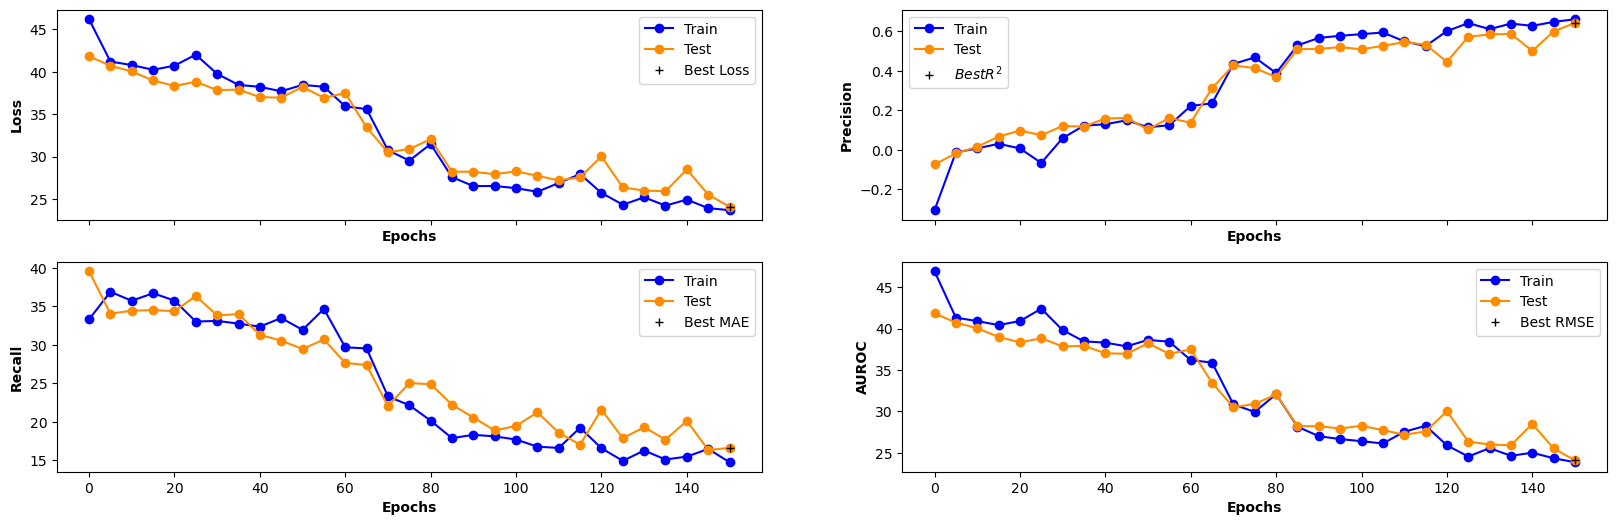

In [15]:
n = 0
last_epoch = epochs

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True,
                                    figsize=(20, 6))

axs[0,0].plot(range(0,last_epoch,5)[n:], loss_train[n:], 'o-', label = 'Train', color = 'blue')
axs[0,0].plot(range(0,last_epoch,5)[n:], loss_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[0,0].plot(best_epoch, best_loss, '+', label = 'Best Loss', color = 'black')
axs[0,0].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[0,0].set_ylabel('Loss', fontweight ='bold', fontsize = 10)
axs[0,0].legend()

axs[0,1].plot(range(0,last_epoch,5)[n:], prec_train[n:], 'o-', label = 'Train', color = 'blue')
axs[0,1].plot(range(0,last_epoch,5)[n:], prec_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[0,1].plot(best_epoch, best_r2, '+', label = '$Best R^2$', color = 'black')
axs[0,1].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[0,1].set_ylabel('Precision', fontweight ='bold', fontsize = 10)
axs[0,1].legend()

axs[1,0].plot(range(0,last_epoch,5)[n:], rec_train[n:], 'o-', label = 'Train', color = 'blue')
axs[1,0].plot(range(0,last_epoch,5)[n:], rec_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[1,0].plot(best_epoch, best_mae, '+', label = 'Best MAE', color = 'black')
axs[1,0].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[1,0].set_ylabel('Recall', fontweight ='bold', fontsize = 10)
axs[1,0].legend()

axs[1,1].plot(range(0,last_epoch,5)[n:], roc_train[n:], 'o-', label = 'Train', color = 'blue')
axs[1,1].plot(range(0,last_epoch,5)[n:], roc_test[n:], 'o-', label = 'Test', color = 'darkorange')
axs[1,1].plot(best_epoch, best_rmse, '+', label = 'Best RMSE', color = 'black')
axs[1,1].set_xlabel('Epochs', fontweight ='bold', fontsize = 10)
axs[1,1].set_ylabel('AUROC', fontweight ='bold', fontsize = 10)
axs[1,1].legend()

plt.show()

In [16]:
import pandas as pd
import plotly.express as px
import molplotly

In [17]:
df = pd.DataFrame()
df = df.assign(y=best_y, predicted=best_pred, ligand = best_mols[:,0], substrate = best_mols[:,1], boron = best_mols[:,2])
df.head()

,y,predicted,ligand,substrate,boron
0,79.0,102.211197,C=CCC1=C[C@@]2(C)C=C[C@H]1[C@](C)(OC)C2,O=C1C=CCCC1,OB(O)c1ccccc1
1,2.5,8.723085,C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2,CCCCC/C=C/C(C)=O,OB(O)c1ccccc1
2,33.0,5.736318,CC1(C)[C@@H]2C=C(c3ccccc3)[C@@]1(C)C=C2c1ccccc1,COC(=O)/C=C/C(=O)OC,OB(O)c1ccccc1
3,1.0,5.488176,CC1(C)[C@@H]2C=C(c3ccccc3)[C@@]1(C)C=C2c1ccccc1,CC(C)(C)OC(=O)/C=C\C(=O)OC(C)(C)C,OB(O)c1ccccc1
4,25.0,5.873148,CC1(C)[C@@H]2C=C(c3ccccc3)[C@@]1(C)C=C2c1ccccc1,Cc1ccc(/C=C/[N+](=O)[O-])cc1,OB(O)c1ccccc1


In [19]:
fig_scatter = px.scatter(df,
                         x="y",
                         y="predicted",
                         title='Regression with many smiles columns!',
                         labels={'y': 'Measured ee',
                                 'predicted': 'Predicted ee'},
                         width=1200,
                         height=800)

app_scatter = molplotly.add_molecules(fig=fig_scatter,
                                      df=df,
                                    #   smiles_col='Base_SMILES'
                                      smiles_col=['ligand', 'substrate', 'boron'],
                                      )

# change the arguments here to run the dash app on an external server and/or change the size of the app!
app_scatter.run_server(mode='inline', port=1000, height=1000)

Dash is running on http://arm64-apple-darwin20.0.0:1000/



nodename nor servname provided, or not known


KeyboardInterrupt: 

In [15]:
from torch_geometric.explain import Explainer, GNNExplainer

In [16]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='probs',
    ),
)

In [17]:
explain = DataLoader(ligands[test_idx[0]])
mol = next(iter(explain))
mol

DataBatch(x=[72, 6], edge_index=[2, 150], edge_attr=[150, 2], y=[1], category=[1], ligand=[1], substrate=[1], boron=[1], index=[1], batch=[72], ptr=[2])

In [18]:
explanation = explainer(x = mol.x, edge_index=mol.edge_index,  batch_index=mol.batch)

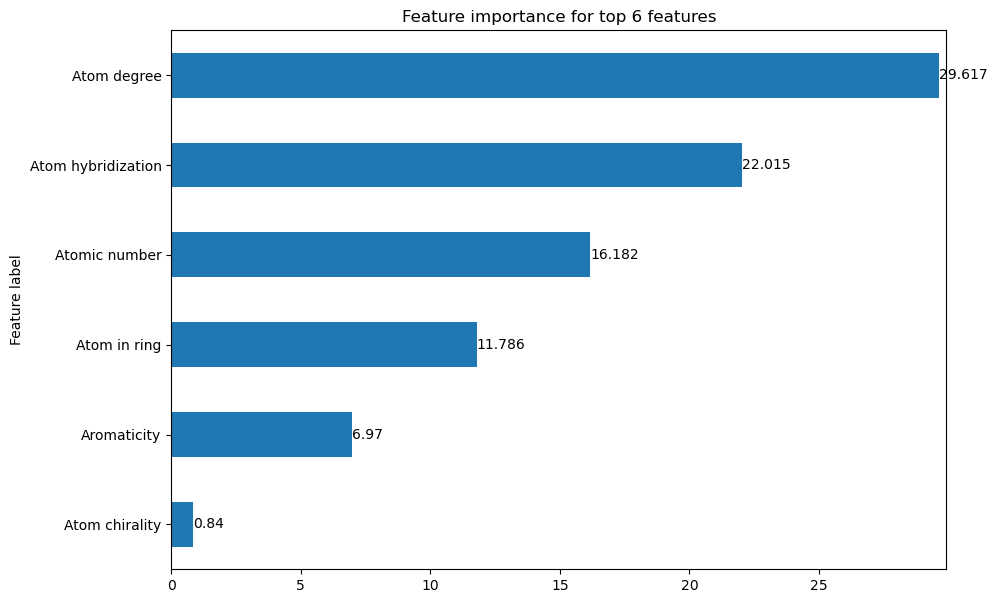

In [19]:
explanation.visualize_feature_importance(path=None, top_k=7, feat_labels = ['Atomic number', 'Atom degree', 'Atom hybridization', 'Aromaticity', 'Atom in ring', 'Atom chirality'])

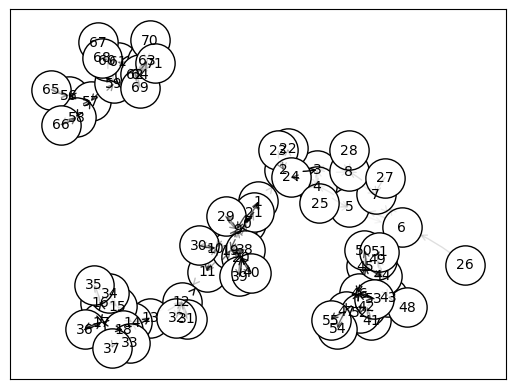

In [20]:
explanation.visualize_graph(None)

In [21]:
import networkx as nx
from torch_geometric.utils import to_networkx

In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, mol='l', draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in list(g.nodes(data=True)):
        if data['mol'] == mol:
            node_labels[u] = data['name']
        else:
            g.remove_node(u)
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]

    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Reds,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = {1:'H', 5: 'B', 6:'C', 7:'N', 8:'O', 9:'F', 15:'P', 16:'S', 
                17:'Cl', 33:'As', 34:'Se', 35:'Br', 53:'I'}
    
    ligand_atoms = rdmolops.AddHs(Chem.MolFromSmiles(data.ligand)).GetNumAtoms()
    substrate_atoms = rdmolops.AddHs(Chem.MolFromSmiles(data.substrate)).GetNumAtoms()
    boron_atoms = rdmolops.AddHs(Chem.MolFromSmiles(data.boron)).GetNumAtoms()
    
    g = to_networkx(data, node_attrs=['x'])

    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'][0]]
        if u < ligand_atoms:
            data['mol'] = 'l'
        elif ligand_atoms <= u < substrate_atoms+ligand_atoms:
            data['mol'] = 's'
        else:
            data['mol'] = 'b'
        del data['x']
    return g

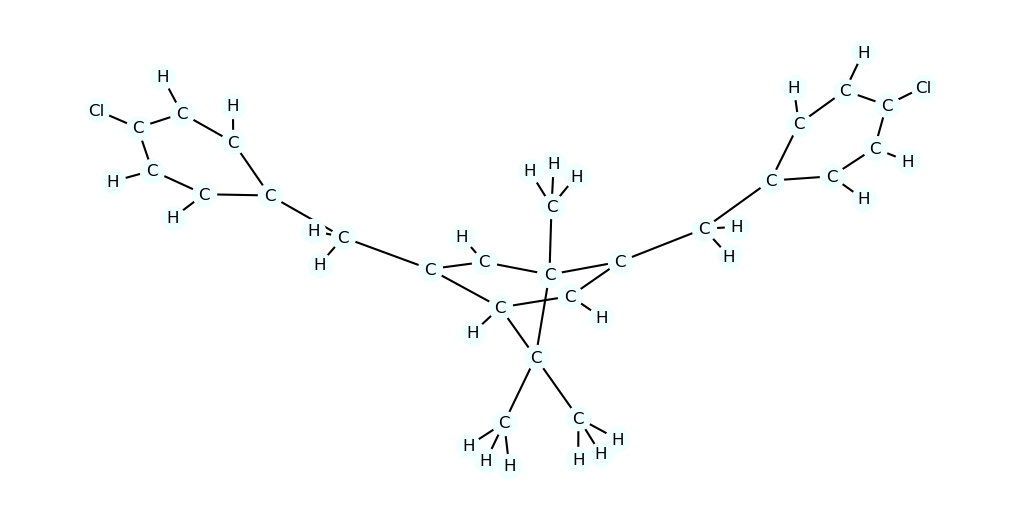

In [23]:
data = ligands[test_idx[0]][9]
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, mol='l')

In [24]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [25]:
from collections import defaultdict

In [26]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

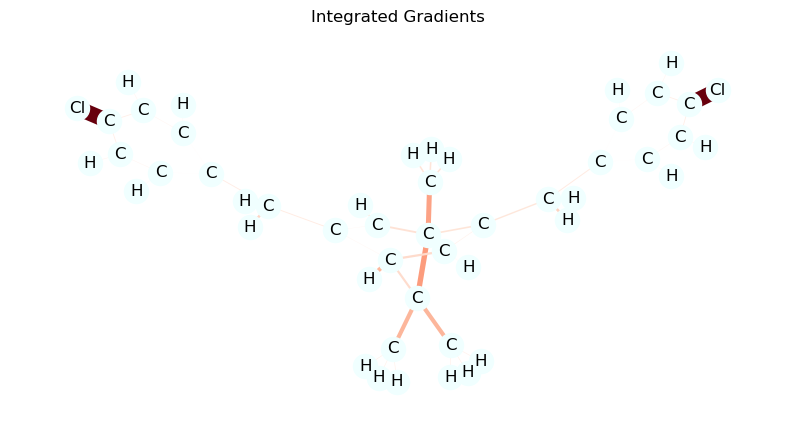

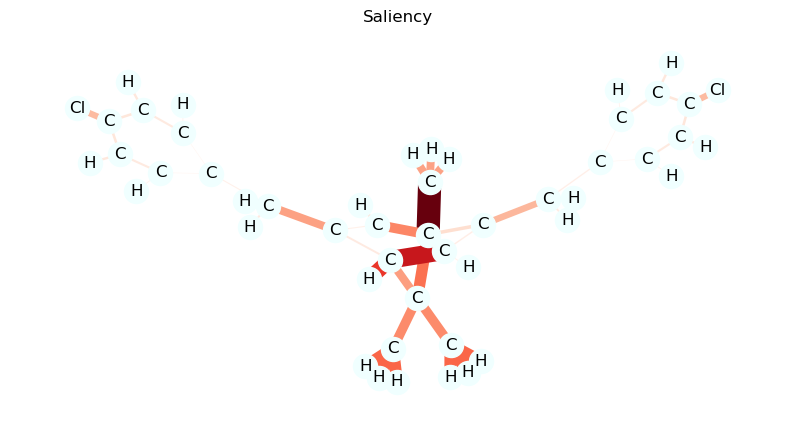

In [27]:
data = ligands[test_idx[0]][9]

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict, mol = 'l')